# Seasonality analysis

In [40]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
symbol = '^GSPC'    # S&P 500




# set maximum number of years to analyze
max_num_of_years = 10


# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: ^GSPC

* **Max years to analyse**: 2022 until earliest 2013

In [41]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')


# set correct frequency
df = df.asfreq('B')

# fill up missing values
df = df.fillna(method='ffill')



D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _^GSPC_

* From 30.12.27 to 07.07.23

## Statistics:

              Close
count  24921.000000
mean     587.879370
std      936.713380
min        4.400000
25%       24.309999
50%      101.250000
75%      964.000000
max     4796.560059


## Data:

                  Close
Date                   
1927-12-30    17.660000
1928-01-02    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
...                 ...
2023-07-03  4455.589844
2023-07-04  4455.589844
2023-07-05  4446.819824
2023-07-06  4411.589844
2023-07-07  4398.950195

[24921 rows x 1 columns]


In [42]:
# prepare range of max 5 years or smaller if dataframe is smaller
firstDay = pd.to_datetime(str((df.index.year.min()+1 if ((df.index.year.max()-1) - (df.index.year.min()+1)) < max_num_of_years else df.index.year.max() - max_num_of_years)) + '-01-01')
lastDay = pd.to_datetime(str(df.index.year.max()-1) + '-12-31')
rangeMax5yrs = pd.date_range(firstDay, lastDay, freq='D')

# get actual number of calculated years for dataframe
rangeNumOfYears = rangeMax5yrs.max().year - rangeMax5yrs.min().year + 1

def dfToAnnualLongForm(inputDf):
    # Create new dataframe
    annualDf = pd.DataFrame(data=inputDf)

    # set correct frequency for better comparison
    annualDf = annualDf.asfreq('d')

    # fill up missing values for better comparison
    annualDf = annualDf.fillna(method='ffill')

    # Drop Feb. 29th of leap years for better comparison
    annualDf = annualDf[~((annualDf.index.month == 2) & (annualDf.index.day == 29))] 

    # Create year and day/month columns
    annualDf['Year'], annualDf['Day'] = annualDf.index.year, annualDf.index.strftime('%m-%d')

    # crop dataframe to max 5 last full years and change to multiindex for plotting
    annualDf = annualDf[rangeMax5yrs.min():rangeMax5yrs.max()].reset_index().drop('Date', axis=1).set_index(['Day', 'Year']).sort_index(level=0)

    return annualDf


annualDf = dfToAnnualLongForm(df)

D('## Initial data overview')
annualDf


## Initial data overview

Close
Day   Year             
01-01 2013  1426.189941
      2014  1848.359985
      2015  2058.899902
      2016  2043.939941
      2017  2238.830078
...                 ...
12-31 2018  2506.850098
      2019  3230.780029
      2020  3756.070068
      2021  4766.180176
      2022  3839.500000

[3650 rows x 1 columns]

In [43]:
#periodNames = ['seasonal_' + str(i) for i in periods]

decompDf = pd.DataFrame(data=df)

# crop dataframe to max 5 last full years
decompDf = decompDf[rangeMax5yrs.min():pd.to_datetime('today')]

# prepare the 3 dataframes for seasonal, trend and residual
seasonalDecompDf = pd.DataFrame()
trendDecompDf = pd.DataFrame()
residDecompDf = pd.DataFrame()

# simplest form of STL
decomposeSimpleStl = STL(decompDf['Close'], period=365)
decomposeSimpleRes = decomposeSimpleStl.fit()

seasonalDecompDf['Simple STL seasonal'] = decomposeSimpleRes.seasonal
trendDecompDf['Simple STL trend'] = decomposeSimpleRes.trend
residDecompDf['Simple STL residual'] = decomposeSimpleRes.resid

# simplest form of STL
decomposeRobustStl = STL(decompDf['Close'], period=365, robust=True)
decomposeRobustRes = decomposeSimpleStl.fit()

seasonalDecompDf['Robust STL seasonal'] = decomposeRobustRes.seasonal
trendDecompDf['Robust STL trend'] = decomposeRobustRes.trend
residDecompDf['Robust STL residual'] = decomposeRobustRes.resid


# prepare annual dataframes with multiindex
annunalSeasonalDecompDf = dfToAnnualLongForm(seasonalDecompDf)
annunalTrendDecompDf = dfToAnnualLongForm(trendDecompDf)
annunalResidDecompDf = dfToAnnualLongForm(residDecompDf)

#pd.set_option('display.max_rows', None)

D('## Seasonal decomposition')
print(seasonalDecompDf)
print(annunalSeasonalDecompDf)

## Seasonal decomposition

            Simple STL seasonal  Robust STL seasonal
Date                                                
2013-01-01           -70.244628           -70.244628
2013-01-02           -51.761512           -51.761512
2013-01-03           -45.899954           -45.899954
2013-01-04           -34.495493           -34.495493
2013-01-07           -37.486025           -37.486025
...                         ...                  ...
2023-07-03           409.300846           409.300846
2023-07-04           424.469507           424.469507
2023-07-05           442.910424           442.910424
2023-07-06           382.238958           382.238958
2023-07-07           334.245475           334.245475

[2744 rows x 2 columns]
            Simple STL seasonal  Robust STL seasonal
Day   Year                                          
01-01 2013           -70.244628           -70.244628
      2014            58.218808            58.218808
      2015            19.649480            19.649480
      2016           

In [44]:
#monthlyDf = pd.DataFrame()
#numOfYears = 0
#for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues
#
#
#montlyMean = monthlyDf.mean(axis=1)
#monthlyStd = monthlyDf.std(axis=1)
#monthlyMax = monthlyDf.max(axis=1)
#monthlyDf['mean'] = montlyMean
#monthlyDf['std'] = monthlyStd
#
#monthlyDf['meanPositive'] = monthlyDf['mean'] > 0
#
#range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
#monthlyDf['date'] = range
#monthlyDf = monthlyDf.set_index('date')
#monthlyDf.index = monthlyDf.index.strftime('%b')
#
#D('## Monthly mean')
#monthlyDf

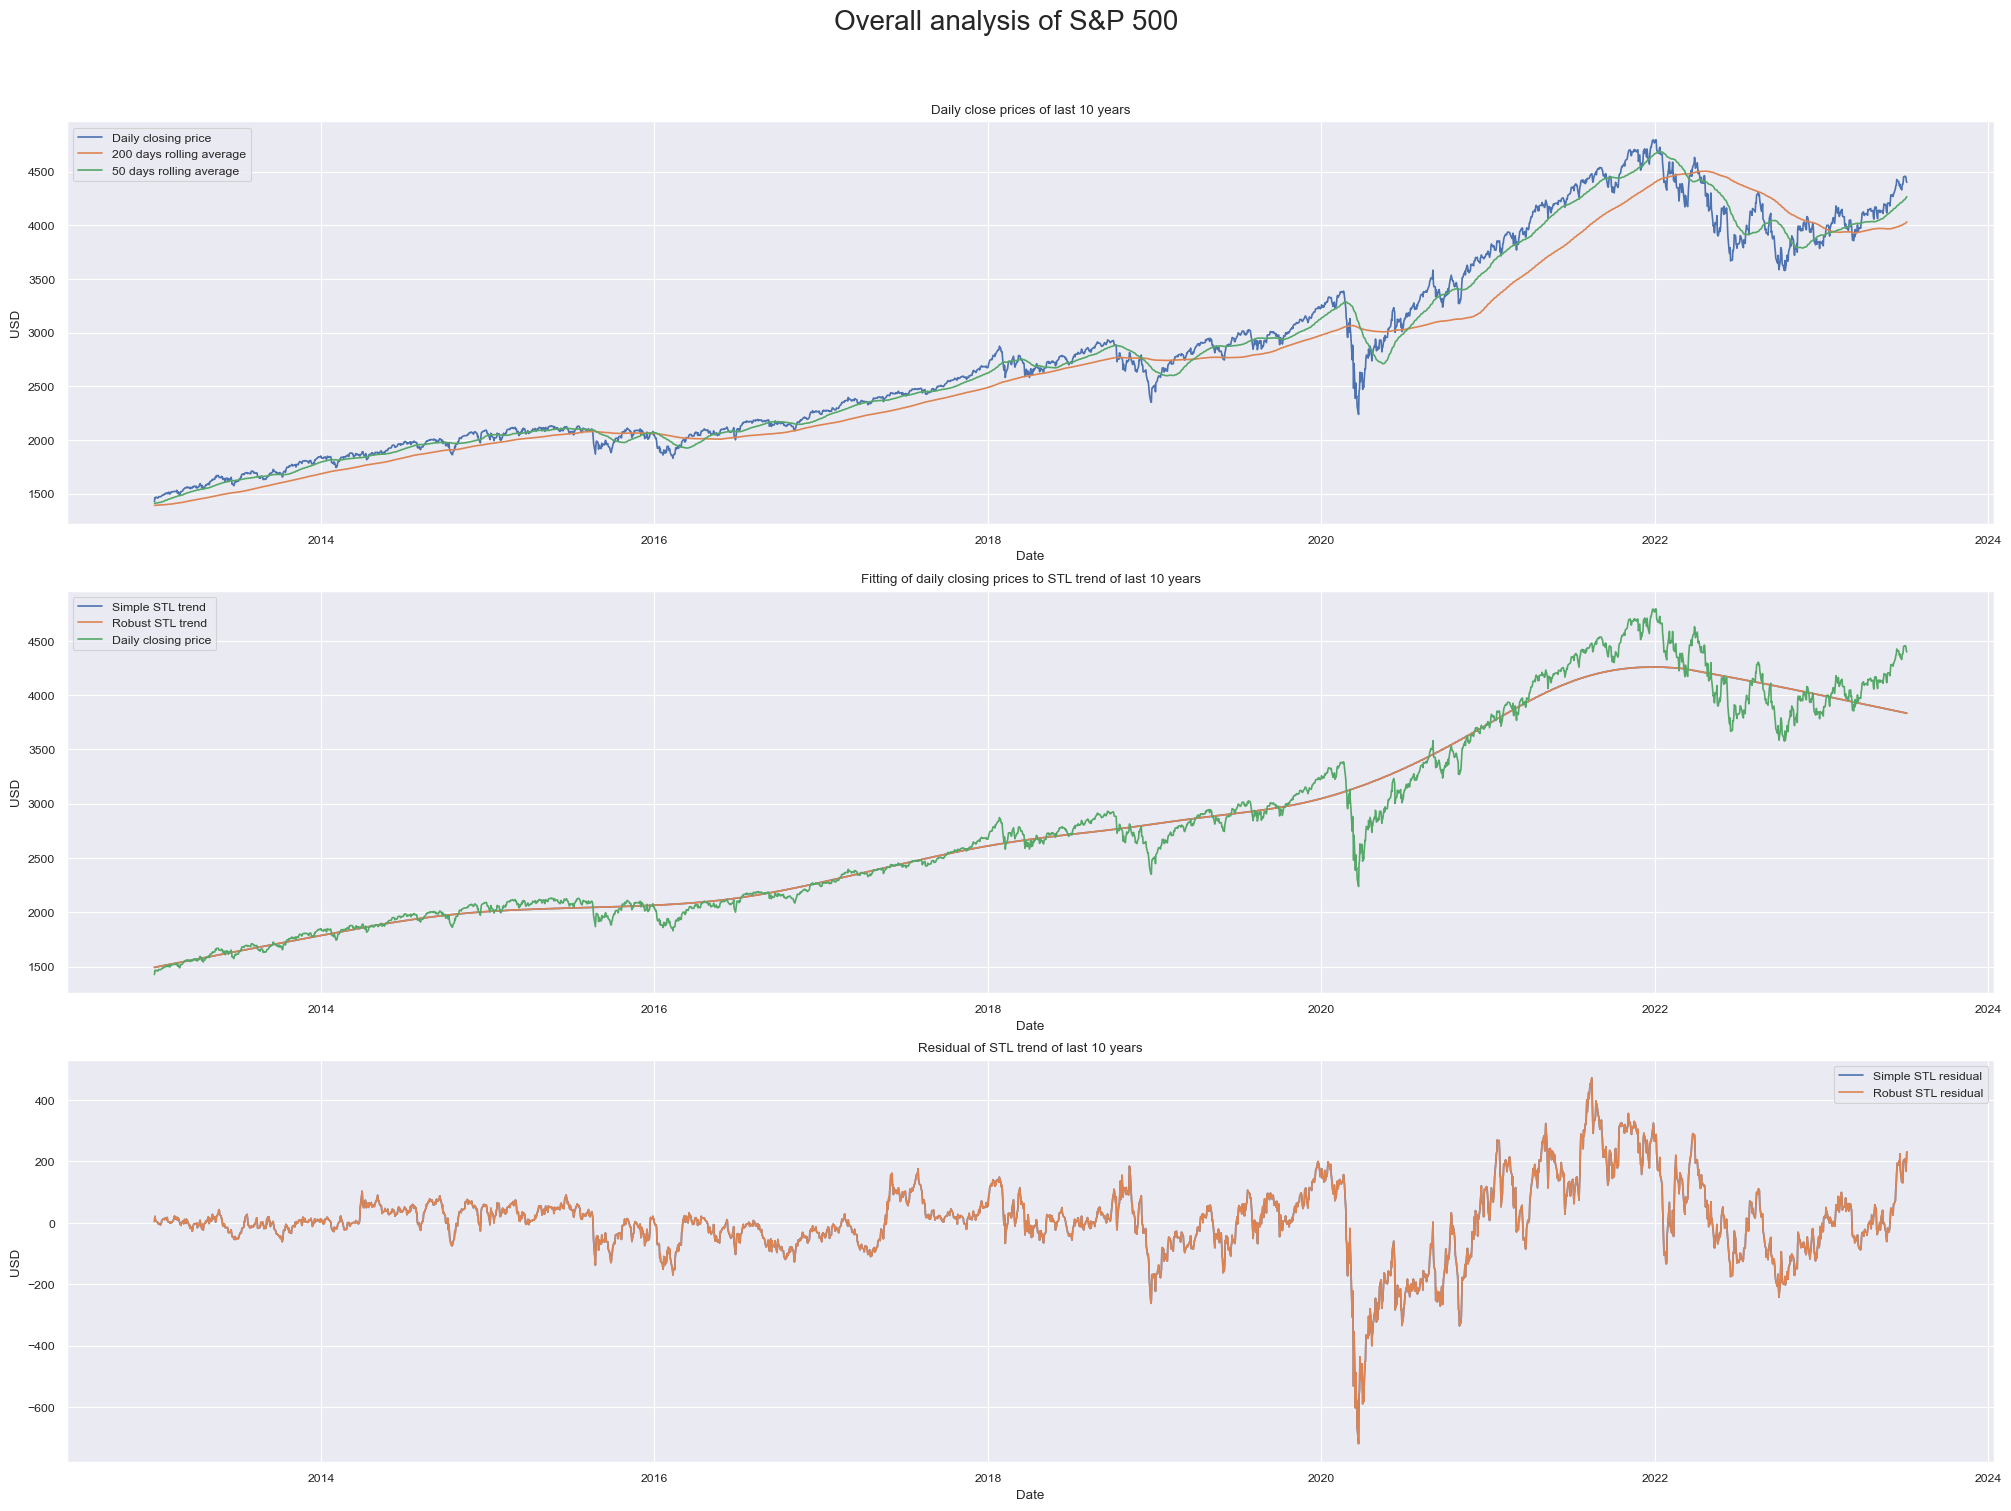

In [45]:
# setup general figure size
generalPlotWidth = 20
generalSubPlotHight = 5

rolling_narrow_resolution = 50
rolling_wide_resolution = 200

numSubPlots = 3
fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
sns.set_theme('paper')
fig.suptitle(f'Overall analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

# Plot overall closing prices of last x years
overallDf = pd.DataFrame(data=df)
overallDf[f'{rolling_wide_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_wide_resolution).mean()
overallDf[f'{rolling_narrow_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_narrow_resolution).mean()
overallDf.rename(columns={'Close':'Daily closing price'}, inplace=True)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Daily close prices of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall closing prices of last x years with STL trend
overallDf = pd.DataFrame(data=trendDecompDf)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
overallDf['Daily closing price'] = df[rangeMax5yrs.min():pd.to_datetime('today')]['Close']
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Fitting of daily closing prices to STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall STL residual of last x years with STL trend
overallDf = pd.DataFrame(data=residDecompDf)
sns.lineplot(data=overallDf[['Simple STL residual', 'Robust STL residual']], dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Residual of STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1

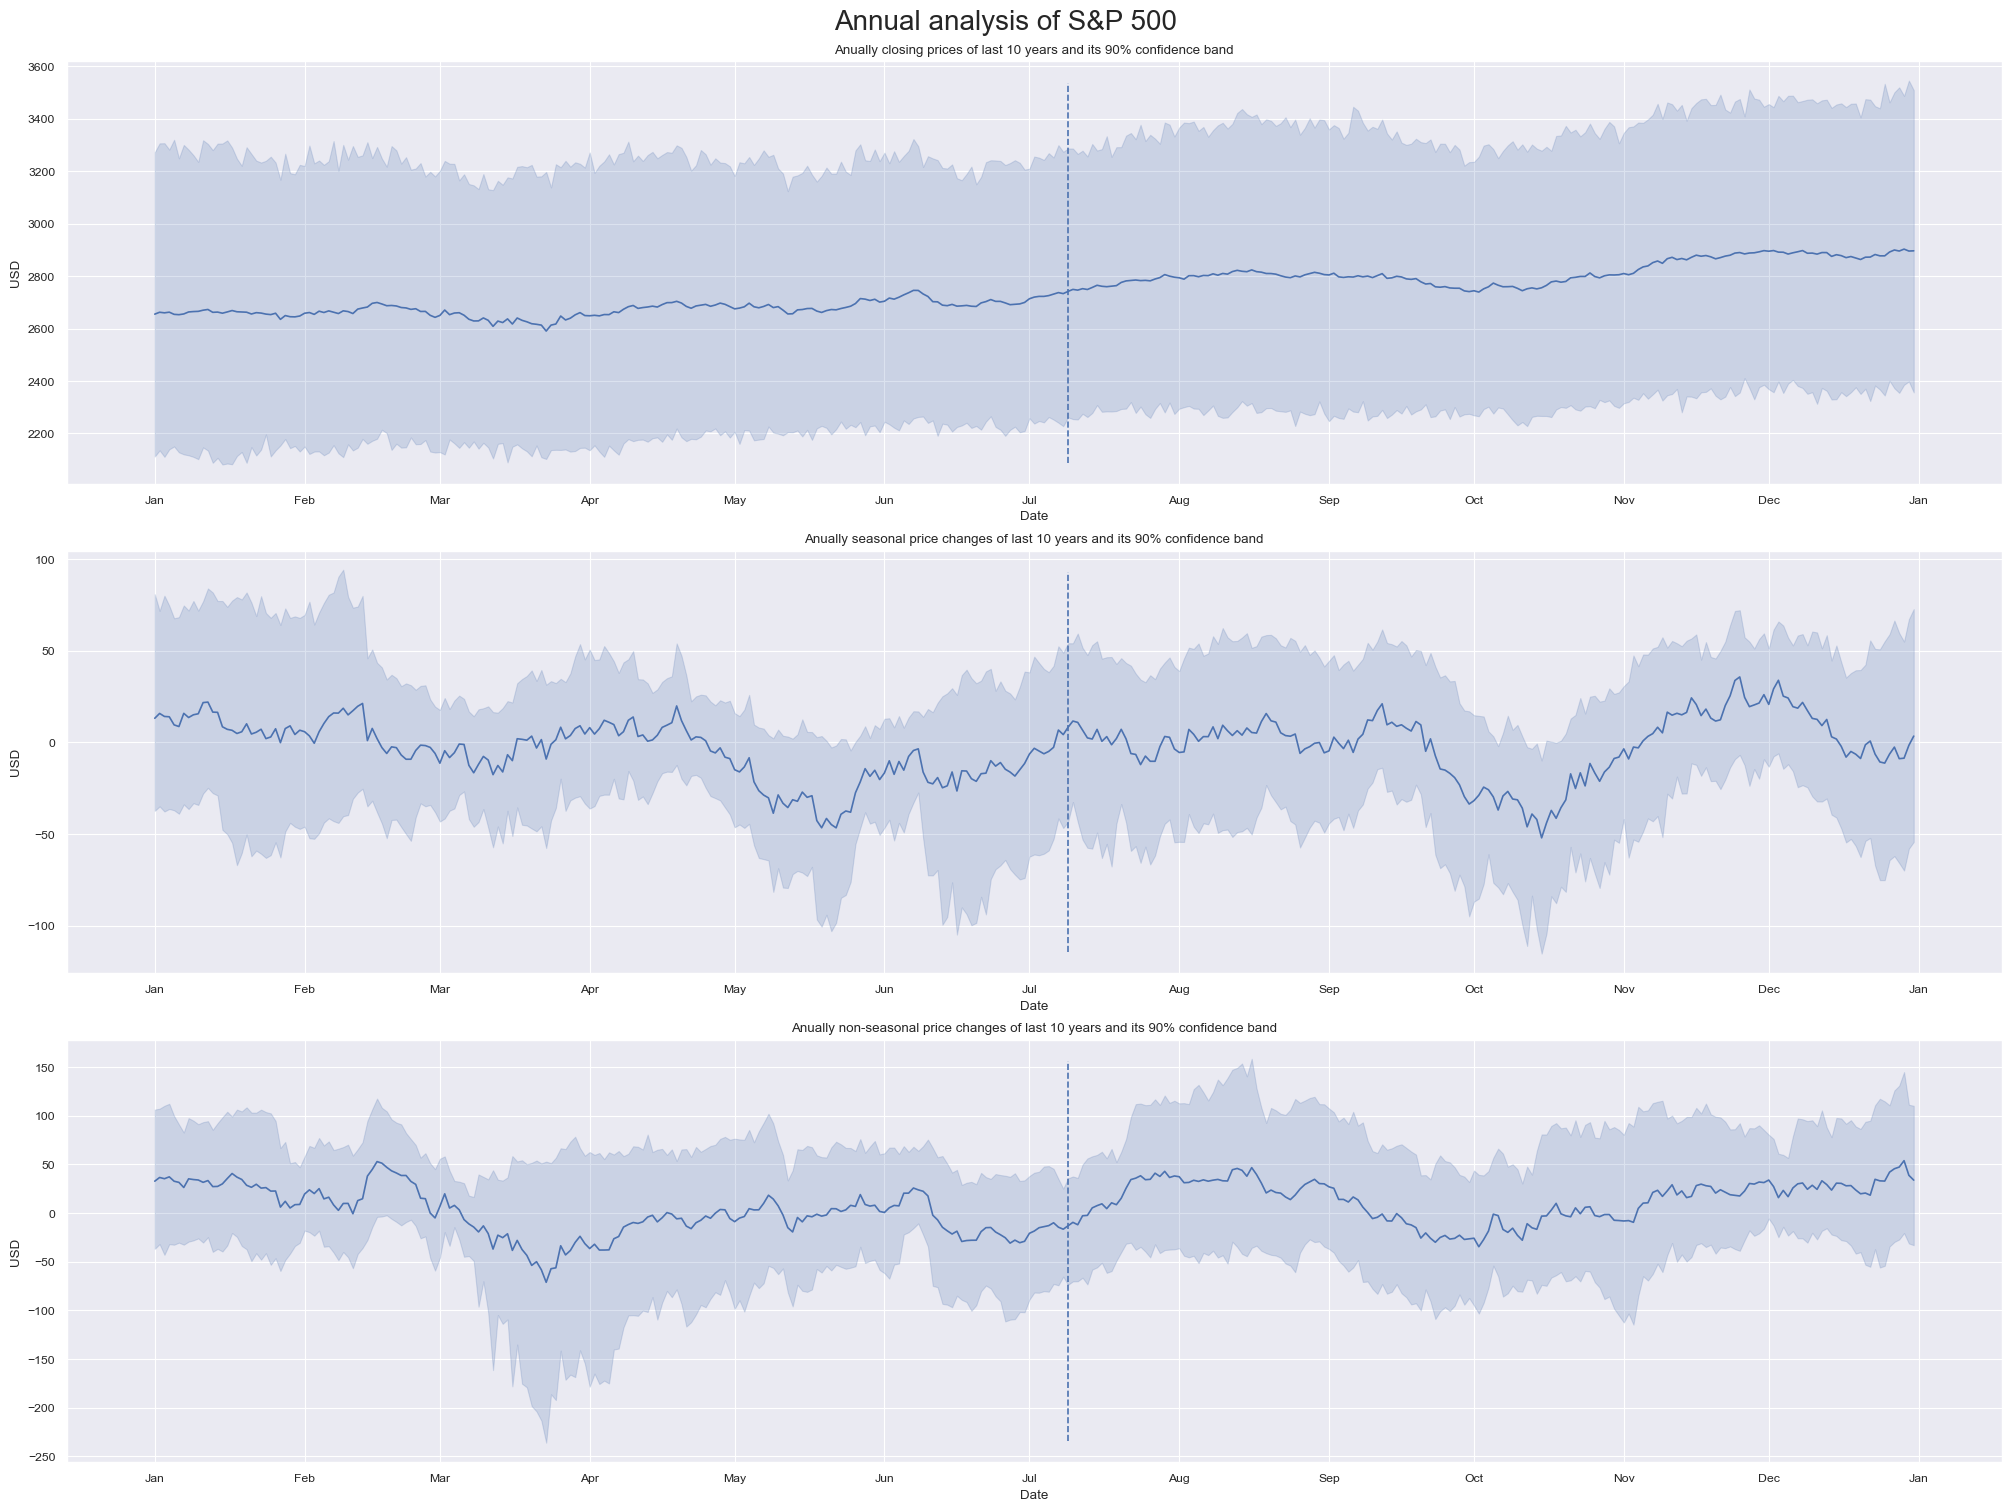

In [46]:
numSubPlots = 3
fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
sns.set_theme('paper')
fig.suptitle(f'Annual analysis of {ticker.info["longName"]}', fontsize=20)

currentAxis = 0

# Plot annual closing prices with confidence band
sns.lineplot(data=annualDf, x='Day', y='Close', ax=axs[currentAxis], sort=True)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually closing prices of last {rangeNumOfYears} years and its 90% confidence band')
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


# Plot annual seasonal prices with confidence band
#        if seasonalityInPercent:
#            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
#        else:
#            usedAnnualDf = annualDf[col]
sns.lineplot(data=annunalSeasonalDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL seasonal')
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually seasonal price changes of last {rangeNumOfYears} years and its 90% confidence band')
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


# Plot annual residual prices with confidence band
sns.lineplot(data=annunalResidDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL residual')
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually non-seasonal price changes of last {rangeNumOfYears} years and its 90% confidence band')
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1
